In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import leap
from leap import LeapForCausalLM, LeapConfig, MultiheadLeap
from lstm import LstmForCausalLM
from transformers import (PreTrainedTokenizerFast, TrainingArguments,
                          Trainer, default_data_collator,
                          GPT2Config, GPT2LMHeadModel)

from datasets import load_dataset, Dataset, DatasetDict, load_from_disk
from torch.utils.data import Subset

# word level tokenizer as per wikitext modeling
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import WordLevelTrainer

import math
import copy
from itertools import chain

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np

import logging
logging.disable(logging.INFO)

C:\Users\micha\anaconda3\lib\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [ ]:
# globals
param_data_ratio = 1 / 10
seq_len = 2048

# hyperparameters
training_args = TrainingArguments(
    output_dir = "./results",
    logging_strategy = "steps",
    evaluation_strategy = "steps",
    logging_steps = 1000,
    report_to = "none",
    learning_rate = 1e-3,
    lr_scheduler_type = "cosine",
    warmup_ratio = .05,
    num_train_epochs = 1,
    per_device_train_batch_size = 12,
    per_device_eval_batch_size = 12,
    max_grad_norm = 1,
    fp16 = True,
    log_level = 'error'
)

# see appendix for creating this file
lm_dataset = load_from_disk('8192_wikitext.dt')

## helper functions

In [ ]:
def subset_data(dataset, num_parameters, param_data_ratio):
    dataset = DatasetDict(copy.deepcopy(dataset))
    subset_num_tokens = num_parameters / param_data_ratio
    
    global seq_len
    num_rows = int(subset_num_tokens) // seq_len

    training_set = dataset["train"]
    dataset["train"] = Dataset.from_dict(training_set[:num_rows+1])
    
    real_num_tokens = len(dataset["train"]) * seq_len
    
    dataset.set_format('pt')
    return dataset

def run_training(hidden_size, n_head = None):
    # calculate number of layers needed based on levine 2020
    n_layer = round((math.log(hidden_size) - 5.039) / 5.55e-2)
    n_layer = max(1, n_layer)
    
    config = LeapConfig(
        hidden_size = hidden_size, n_layer = n_layer, n_head = n_head,
        vocab_size = 8192, n_positions = seq_len,
        use_local_att = True, window_sizes = None,
        initializer_range = 1 / hidden_size**.5,
        hidden_dropout_prob = 0 # no dropout bc one epoch
    )
    model = LeapForCausalLM(config)

    # get number of parameters
    total_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    # get rid of embedding parameters
    token_embeddings = 8192 * hidden_size
    position_embeddings = seq_len * hidden_size
    non_embedding_parameters = total_parameters - token_embeddings - position_embeddings

    # subset dataset using global lm_dataset
    global lm_dataset
    subset_datasets = subset_data(lm_dataset, non_embedding_parameters, param_data_ratio)

    trainer = Trainer(
        model=model,
        args=training_args,
        data_collator=default_data_collator,
        train_dataset=subset_datasets["train"],
        eval_dataset=subset_datasets["validation"],
    )

    trainer.train()
    
    best_valid_loss = trainer.evaluate()["eval_loss"]

    # save gpu memory
    del trainer
    del model
    del subset_datasets
    torch.cuda.empty_cache()
    
    return non_embedding_parameters, best_valid_loss

# TRAINING FUNCTION

In [ ]:
sizes = [
    {"hidden_size": 64, "n_head": 1},
    {"hidden_size": 96, "n_head": 1},
    {"hidden_size": 128, "n_head": 2},
    {"hidden_size": 160, "n_head": 2},
    {"hidden_size": 176, "n_head": 2},
    {"hidden_size": 192, "n_head": 3},
    {"hidden_size": 224, "n_head": 4},
    {"hidden_size": 256, "n_head": 4},
]

def powerlaw(n, n_c, a):
    return (n_c / n)**a

def try_scaling():
    params = []
    losses = []

    for size in sizes:
        param, loss = run_training(**size)
        params.append(param)
        losses.append(loss)
    
    # graphing and powerlaws 
    params = np.array(params, dtype = 'int64')
    losses = np.array(losses, dtype = 'float64')
    
    # powerlaw fitting using only the biggest 4 runs (for better exponent estimate)
    (n_c, a), _ = curve_fit(powerlaw, params[-4:], losses[-4:], maxfev=10000, p0 = np.array([9e13, .076]))
    
    plt.loglog()
    plt.scatter(x = params, y = losses)
    plt.plot(params, powerlaw(params, n_c, a), linestyle = '--')
    plt.show()
    
    print("\n===============RAW NUMBERS===============\n")
    print("Parameters:", list(params))
    print("Losses:", list(losses))
    
    print("\n===============SCALING LAW===============\n")
    print(f"Constant factor N_c: {n_c:.0}, Exponent: {a:.3}")

# Ablations

The idea here is instead of changing the source code in LEAP.py over and over again and then running personal experiments, that it makes much more sense to record this stuff in a notebook. Still it seems like a bad option to have to write a bunch of if statements about which little abalation to use. The solution, monkey patching! We will rewrite the LEAP forward function before each abalation test. An example is shown, and this notebook will be annotated

## original forward function

In [ ]:
def forward(self, mod):        
    batch_size, seq_len, hidden_size = mod.shape

    # projections so each matrix has its own purpose
    q, f, k, v = self.projections(mod).chunk(4, dim = -1)

    # reshape for multihead formulation
    q = q.reshape(batch_size, seq_len, self.n_head, self.head_size)
    f = f.reshape(batch_size, seq_len, self.n_head, self.head_size)
    k = k.reshape(batch_size, seq_len, self.n_head, self.head_size)
    v = v.reshape(batch_size, seq_len, self.n_head, self.head_size)

    # unparameterized norming of vectors so dot products don't explode (also why it is after reshaping)
    if self.rescale:
        q = self._real_norm(q)
        f = self._real_norm(f)
        k = self._real_norm(k)
        v = self._real_norm(v)

    # dropout regularization (keys don't need dropout as they are always dotted with a dropped out vector)
    q = self.drop(q)
    f = self.drop(f)
    v = self.drop(v)

    # manual "matrix dot product" for speed (in einsum notation "bshe, bshe->bsh") with scaling
    focus_logits = (f * k).sum(dim = -1) * self.scaling_factor

    # apply dropout to logits so that all tokens will have a chance at getting focus
    focus_logits = self.drop(focus_logits)

    # manual softmax within cumulative sum
    focus_weights = torch.exp(focus_logits)
    focus_weights = focus_weights.unsqueeze(-1)

    # normalization term for softmax
    cumulative_weights = torch.cumsum(focus_weights, dim = 1)
    cumulative_weights = cumulative_weights - self._window_align(cumulative_weights)

    focused_k = self._w_focus(focus_weights, cumulative_weights, k)
    focused_v = self._w_focus(focus_weights, cumulative_weights, v)

    # querying by measuring dot product alignment (with scaling)
    alignment = torch.sigmoid((q * focused_k).sum(dim = -1) * self.scaling_factor)
    attention = alignment.unsqueeze(-1) * focused_v

    # concat heads
    attention = attention.reshape(batch_size, seq_len, hidden_size)

    return attention

# monkey patched since now LEAP has been adapted
leap.MultiheadLeap.forward = forward

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,4.861500,4.326162


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,4.835300,4.250451
2000,4.061200,3.938624


<ipython-input-4-38cc3ad2ea7c>:13: RuntimeWarning: invalid value encountered in power
  return (n_c / n)**a


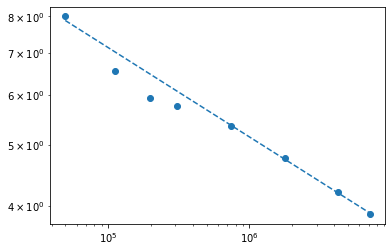


===============RAW NUMBERS===============

Parameters: [49856, 111648, 198016, 308960, 746944, 1776768, 4229344, 7099136]
Losses: [7.993268966674805, 6.551533222198486, 5.93641996383667, 5.764010429382324, 5.351748943328857, 4.7581892013549805, 4.203468322753906, 3.8781819343566895]

===============SCALING LAW===============

Constant factor N_c: 1e+11, Exponent: 0.142


In [ ]:
try_scaling()

## monkey patched

In [ ]:
def forward(self, mod, attention_mask = None):        
    print("we abalate the entirety of LEAP here :)", end = '\r')
    return mod

leap.MultiheadLeap.forward = forward

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,5.158200,4.882760


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,5.162200,4.872939
2000,4.788400,4.786027


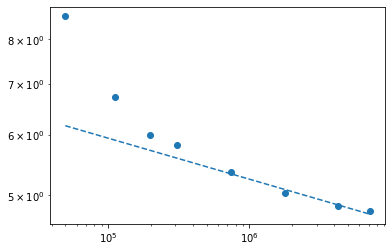


===============RAW NUMBERS===============

Parameters: [49856, 111648, 198016, 308960, 746944, 1776768, 4229344, 7099136]
Losses: [8.569775581359863, 6.732327938079834, 5.991224765777588, 5.811376094818115, 5.3721489906311035, 5.027792930603027, 4.84218692779541, 4.763546943664551]

===============SCALING LAW===============

Constant factor N_c: 3e+19, Exponent: 0.0537


In [ ]:
try_scaling()

interesting to see how the scaling law bends so much when there's not attention/sequence modeling

### Try using elu and no rescaling

The idea here is that rescaling is a somewhat hacky solution and to some degree makes the softmax more like an odd sigmoid, ELU might work better anyways. To be exact, the norming will be removed, the scaling will just be normal dot product scaling and elu+1 will be used instead of exp

In [ ]:
def forward(self, mod):       
    batch_size, seq_len, hidden_size = mod.shape

    # projections so each matrix has its own purpose
    q, f, k, v = self.projections(mod).chunk(4, dim = -1)

    # reshape for multihead formulation
    q = q.reshape(batch_size, seq_len, self.n_head, self.head_size)
    f = f.reshape(batch_size, seq_len, self.n_head, self.head_size)
    k = k.reshape(batch_size, seq_len, self.n_head, self.head_size)
    v = v.reshape(batch_size, seq_len, self.n_head, self.head_size)

    # dropout regularization (keys don't need dropout as they are always dotted with a dropped out vector)
    q = self.drop(q)
    f = self.drop(f)
    v = self.drop(v)

    # manual "matrix dot product" for speed (in einsum notation "bshe, bshe->bsh") with scaling
    focus_logits = (f * k).sum(dim = -1) / self.head_size**.5

    # apply dropout to logits so that all tokens will have a chance at getting focus
    focus_logits = self.drop(focus_logits)

    # manual softmax within cumulative sum
    focus_weights = F.elu(focus_logits) + 1
    focus_weights = focus_weights.unsqueeze(-1)

    # normalization term for softmax
    cumulative_weights = torch.cumsum(focus_weights, dim = 1)
    cumulative_weights = cumulative_weights - self._window_align(cumulative_weights)

    focused_k = self._w_focus(focus_weights, cumulative_weights, k)
    focused_v = self._w_focus(focus_weights, cumulative_weights, v)

    # querying by measuring dot product alignment (with scaling)
    alignment = torch.sigmoid((q * focused_k).sum(dim = -1) / self.head_size**.5)
    attention = alignment.unsqueeze(-1) * focused_v

    # concat heads
    attention = attention.reshape(batch_size, seq_len, hidden_size)

    return attention

leap.MultiheadLeap.forward = forward

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,4.804700,4.281525


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,4.777500,4.205191
2000,4.028900,3.912940


<ipython-input-4-38cc3ad2ea7c>:13: RuntimeWarning: invalid value encountered in power
  return (n_c / n)**a


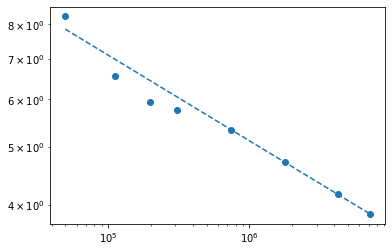


===============RAW NUMBERS===============

Parameters: [49856, 111648, 198016, 308960, 746944, 1776768, 4229344, 7099136]
Losses: [8.239195823669434, 6.551985263824463, 5.93369722366333, 5.746731281280518, 5.330632209777832, 4.704448699951172, 4.171184539794922, 3.8571696281433105]

===============SCALING LAW===============

Constant factor N_c: 9e+10, Exponent: 0.143


In [ ]:
try_scaling()

That's pretty good! better exponent with better loss. I prefer it for stability reasons anyways. Let's try replacing the other activation function too

### Use gelu instead of sigmoid
The original idea was to use a sigmoid to be a simple gating mechanism of whether to pay attention to a head or not. Though with GLU research, it seems to make sense to just use GELU. I think it's worth trying but I likely won't keep this change if it isn't a lot different because it may stop explainability

In [ ]:
def forward(self, mod):       
    batch_size, seq_len, hidden_size = mod.shape

    # projections so each matrix has its own purpose
    q, f, k, v = self.projections(mod).chunk(4, dim = -1)

    # reshape for multihead formulation
    q = q.reshape(batch_size, seq_len, self.n_head, self.head_size)
    f = f.reshape(batch_size, seq_len, self.n_head, self.head_size)
    k = k.reshape(batch_size, seq_len, self.n_head, self.head_size)
    v = v.reshape(batch_size, seq_len, self.n_head, self.head_size)

    # dropout regularization (keys don't need dropout as they are always dotted with a dropped out vector)
    q = self.drop(q)
    f = self.drop(f)
    v = self.drop(v)

    # manual "matrix dot product" for speed (in einsum notation "bshe, bshe->bsh") with scaling
    focus_logits = (f * k).sum(dim = -1) / self.head_size**.5

    # apply dropout to logits so that all tokens will have a chance at getting focus
    focus_logits = self.drop(focus_logits)

    # manual softmax within cumulative sum
    focus_weights = F.elu(focus_logits) + 1
    focus_weights = focus_weights.unsqueeze(-1)

    # normalization term for softmax
    cumulative_weights = torch.cumsum(focus_weights, dim = 1)
    cumulative_weights = cumulative_weights - self._window_align(cumulative_weights)

    focused_k = self._w_focus(focus_weights, cumulative_weights, k)
    focused_v = self._w_focus(focus_weights, cumulative_weights, v)

    # querying by measuring dot product alignment (with scaling)
    alignment = F.gelu((q * focused_k).sum(dim = -1) / self.head_size**.5)
    attention = alignment.unsqueeze(-1) * focused_v

    # concat heads
    attention = attention.reshape(batch_size, seq_len, hidden_size)

    return attention

leap.MultiheadLeap.forward = forward

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,4.798700,4.287963


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,4.774000,4.218589
2000,4.053600,3.941700


<ipython-input-4-38cc3ad2ea7c>:13: RuntimeWarning: invalid value encountered in power
  return (n_c / n)**a


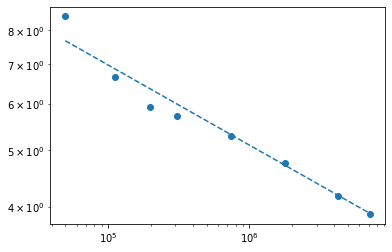


===============RAW NUMBERS===============

Parameters: [49856, 111648, 198016, 308960, 746944, 1776768, 4229344, 7099136]
Losses: [8.44904899597168, 6.655923366546631, 5.914546012878418, 5.723958492279053, 5.286169052124023, 4.753070831298828, 4.18115234375, 3.887984275817871]

===============SCALING LAW===============

Constant factor N_c: 2e+11, Exponent: 0.137


In [ ]:
try_scaling()

Ends up worse which is interesting

### LEAP, but ablate queries and keys
I'm quite sure this will be worse, but it's worth checking since it does get rid of some parameters (and can maybe make room for an attention projection)

In [ ]:
def __init__(self, hidden_size, n_head, window_size, rescale = None, dropout = .1):
    super(MultiheadLeap, self).__init__()
    self.n_head = n_head
    self.hidden_size = hidden_size
    self.head_size = hidden_size // n_head
    self.window_size = window_size

    # note: one large projection matrix is equivalent to having seperate projection matrices and is faster
    self.projections = nn.Linear(hidden_size, 3 * hidden_size, bias = False)
    self.drop = nn.Dropout(dropout)


def forward(self, mod):       
    batch_size, seq_len, hidden_size = mod.shape

    # projections so each matrix has its own purpose
    f, f2, v = self.projections(mod).chunk(3, dim = -1)

    # reshape for multihead formulation
    f = f.reshape(batch_size, seq_len, self.n_head, self.head_size)
    f2 = f2.reshape(batch_size, seq_len, self.n_head, self.head_size)
    v = v.reshape(batch_size, seq_len, self.n_head, self.head_size)

    # dropout regularization
    f = self.drop(f)
    v = self.drop(v)

    # manual "matrix dot product" for speed (in einsum notation "bshe, bshe->bsh") with scaling
    focus_logits = (f * f2).sum(dim = -1) / self.head_size**.5

    # apply dropout to logits so that all tokens will have a chance at getting focus
    focus_logits = self.drop(focus_logits)

    # manual softmax within cumulative sum
    focus_weights = F.elu(focus_logits) + 1
    focus_weights = focus_weights.unsqueeze(-1)

    # normalization term for softmax
    cumulative_weights = torch.cumsum(focus_weights, dim = 1)
    cumulative_weights = cumulative_weights - self._window_align(cumulative_weights)
    focused_v = self._w_focus(focus_weights, cumulative_weights, v)

    # concat heads
    attention = focused_v.reshape(batch_size, seq_len, hidden_size)

    return attention

leap.MultiheadLeap.forward = forward
leap.MultiheadLeap.__init__ = __init__

Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,4.840800,4.312184


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,4.829400,4.242418
2000,4.070300,3.968314


<ipython-input-4-38cc3ad2ea7c>:13: RuntimeWarning: invalid value encountered in power
  return (n_c / n)**a


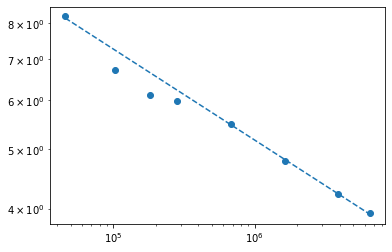


===============RAW NUMBERS===============

Parameters: [45760, 102432, 181632, 283360, 684992, 1629312, 3878112, 6509312]
Losses: [8.204666137695312, 6.725832939147949, 6.113348960876465, 5.989479064941406, 5.483139514923096, 4.7862348556518555, 4.23154354095459, 3.9365174770355225]

===============SCALING LAW===============

Constant factor N_c: 7e+10, Exponent: 0.148


In [ ]:
try_scaling()

apparently better exponent, though is it just that the models are smaller and thus loss is higher? or that the keys aren't reused...? I really can't sign off on it with the loss being higher though

### don't reuse the keys

In [ ]:
def __init__(self, hidden_size, n_head, window_size, rescale = None, dropout = .1):
    super(MultiheadLeap, self).__init__()
    self.n_head = n_head
    self.hidden_size = hidden_size
    self.head_size = hidden_size // n_head
    self.window_size = window_size

    # note: one large projection matrix is equivalent to having seperate projection matrices and is faster
    self.projections = nn.Linear(hidden_size, 5 * hidden_size, bias = False)
    self.drop = nn.Dropout(dropout)
    
def forward(self, mod):       
    batch_size, seq_len, hidden_size = mod.shape

    # projections so each matrix has its own purpose
    q, f, f2, k, v = self.projections(mod).chunk(5, dim = -1)

    # reshape for multihead formulation
    q = q.reshape(batch_size, seq_len, self.n_head, self.head_size)
    f = f.reshape(batch_size, seq_len, self.n_head, self.head_size)
    f2 = f2.reshape(batch_size, seq_len, self.n_head, self.head_size)
    k = k.reshape(batch_size, seq_len, self.n_head, self.head_size)
    v = v.reshape(batch_size, seq_len, self.n_head, self.head_size)

    # dropout regularization (keys don't need dropout as they are always dotted with a dropped out vector)
    q = self.drop(q)
    f = self.drop(f)
    v = self.drop(v)

    # manual "matrix dot product" for speed (in einsum notation "bshe, bshe->bsh") with scaling
    focus_logits = (f * f2).sum(dim = -1) / self.head_size**.5

    # apply dropout to logits so that all tokens will have a chance at getting focus
    focus_logits = self.drop(focus_logits)

    # manual softmax within cumulative sum
    focus_weights = F.elu(focus_logits) + 1
    focus_weights = focus_weights.unsqueeze(-1)

    # normalization term for softmax
    cumulative_weights = torch.cumsum(focus_weights, dim = 1)
    cumulative_weights = cumulative_weights - self._window_align(cumulative_weights)

    focused_k = self._w_focus(focus_weights, cumulative_weights, k)
    focused_v = self._w_focus(focus_weights, cumulative_weights, v)

    # querying by measuring dot product alignment (with scaling)
    alignment = F.gelu((q * focused_k).sum(dim = -1) / self.head_size**.5)
    attention = alignment.unsqueeze(-1) * focused_v

    # concat heads
    attention = attention.reshape(batch_size, seq_len, hidden_size)

    return attention

leap.MultiheadLeap.forward = forward
leap.MultiheadLeap.__init__ = __init__

Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,4.804600,4.277508


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,4.783700,4.208250
2000,4.038000,3.920101
3000,3.865900,3.837835


<ipython-input-4-38cc3ad2ea7c>:13: RuntimeWarning: invalid value encountered in power
  return (n_c / n)**a


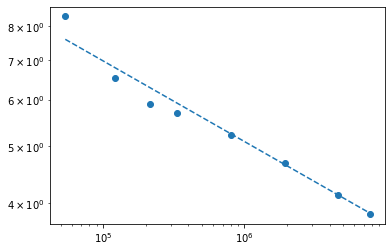


===============RAW NUMBERS===============

Parameters: [53952, 120864, 214400, 334560, 808896, 1924224, 4580576, 7688960]
Losses: [8.308262825012207, 6.526923179626465, 5.892955303192139, 5.691197872161865, 5.228291034698486, 4.689075469970703, 4.1413164138793945, 3.8373472690582275]

===============SCALING LAW===============

Constant factor N_c: 1e+11, Exponent: 0.137


In [ ]:
try_scaling()

Hmm 

### let's try a bilinear layer instead of querying

In [ ]:
def __init__(self, hidden_size, n_head, window_size, rescale = None, dropout = .1):
    super(MultiheadLeap, self).__init__()
    self.n_head = n_head
    self.hidden_size = hidden_size
    self.head_size = hidden_size // n_head
    self.window_size = window_size

    # note: one large projection matrix is equivalent to having seperate projection matrices and is faster
    self.projections = nn.Linear(hidden_size, 4 * hidden_size, bias = False)
    self.drop = nn.Dropout(dropout)
    
def forward(self, mod):       
    batch_size, seq_len, hidden_size = mod.shape

    # projections so each matrix has its own purpose
    q, f, f2, v = self.projections(mod).chunk(4, dim = -1)

    # reshape for multihead formulation
    q = q.reshape(batch_size, seq_len, self.n_head, self.head_size)
    f = f.reshape(batch_size, seq_len, self.n_head, self.head_size)
    f2 = f2.reshape(batch_size, seq_len, self.n_head, self.head_size)
    v = v.reshape(batch_size, seq_len, self.n_head, self.head_size)

    # dropout regularization (keys don't need dropout as they are always dotted with a dropped out vector)
    q = self.drop(q)
    f = self.drop(f)
    v = self.drop(v)

    # manual "matrix dot product" for speed (in einsum notation "bshe, bshe->bsh") with scaling
    focus_logits = (f * f2).sum(dim = -1) / self.head_size**.5

    # apply dropout to logits so that all tokens will have a chance at getting focus
    focus_logits = self.drop(focus_logits)

    # manual softmax within cumulative sum
    focus_weights = F.elu(focus_logits) + 1
    focus_weights = focus_weights.unsqueeze(-1)

    # normalization term for softmax
    cumulative_weights = torch.cumsum(focus_weights, dim = 1)
    cumulative_weights = cumulative_weights - self._window_align(cumulative_weights)

    focused_v = self._w_focus(focus_weights, cumulative_weights, v)

    # querying by measuring dot product alignment (with scaling)
    attention = q * focused_v

    # concat heads
    attention = attention.reshape(batch_size, seq_len, hidden_size)

    return attention

leap.MultiheadLeap.forward = forward
leap.MultiheadLeap.__init__ = __init__

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,4.787700,4.279689


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,4.765100,4.210389
2000,4.043400,3.933537


<ipython-input-4-38cc3ad2ea7c>:13: RuntimeWarning: invalid value encountered in power
  return (n_c / n)**a


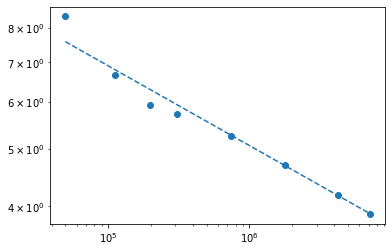


===============RAW NUMBERS===============

Parameters: [49856, 111648, 198016, 308960, 746944, 1776768, 4229344, 7099136]
Losses: [8.354162216186523, 6.649169921875, 5.9314680099487305, 5.713555335998535, 5.257506370544434, 4.700800895690918, 4.17547607421875, 3.8804354667663574]

===============SCALING LAW===============

Constant factor N_c: 2e+11, Exponent: 0.134


In [ ]:
try_scaling()

apparently doesn't do much

### nomalize values?

The if the values aren't normalized, a value may be able to make it past low focus

In [ ]:
def forward(self, mod):       
    batch_size, seq_len, hidden_size = mod.shape

    # projections so each matrix has its own purpose
    q, f, k, v = self.projections(mod).chunk(4, dim = -1)

    # reshape for multihead formulation
    q = q.reshape(batch_size, seq_len, self.n_head, self.head_size)
    f = f.reshape(batch_size, seq_len, self.n_head, self.head_size)
    k = k.reshape(batch_size, seq_len, self.n_head, self.head_size)
    v = v.reshape(batch_size, seq_len, self.n_head, self.head_size)
    
    v = self._real_norm(v)

    # dropout regularization (keys don't need dropout as they are always dotted with a dropped out vector)
    q = self.drop(q)
    f = self.drop(f)
    v = self.drop(v)

    # manual "matrix dot product" for speed (in einsum notation "bshe, bshe->bsh") with scaling
    focus_logits = (f * k).sum(dim = -1) / self.head_size**.5

    # apply dropout to logits so that all tokens will have a chance at getting focus
    focus_logits = self.drop(focus_logits)

    # manual softmax within cumulative sum
    focus_weights = F.elu(focus_logits) + 1
    focus_weights = focus_weights.unsqueeze(-1)

    # normalization term for softmax
    cumulative_weights = torch.cumsum(focus_weights, dim = 1)
    cumulative_weights = cumulative_weights - self._window_align(cumulative_weights)

    focused_k = self._w_focus(focus_weights, cumulative_weights, k)
    focused_v = self._w_focus(focus_weights, cumulative_weights, v)

    # querying by measuring dot product alignment (with scaling)
    alignment = torch.sigmoid((q * focused_k).sum(dim = -1) / self.head_size**.5)
    attention = alignment.unsqueeze(-1) * focused_v

    # concat heads
    attention = attention.reshape(batch_size, seq_len, hidden_size)

    return attention

leap.MultiheadLeap.forward = forward

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,4.811500,4.288779


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,4.787500,4.215901
2000,4.037900,3.919048


<ipython-input-4-38cc3ad2ea7c>:13: RuntimeWarning: invalid value encountered in power
  return (n_c / n)**a


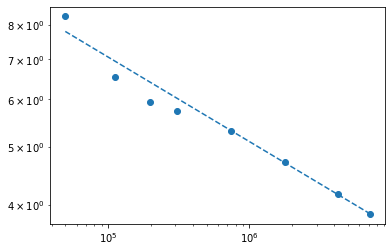


===============RAW NUMBERS===============

Parameters: [49856, 111648, 198016, 308960, 746944, 1776768, 4229344, 7099136]
Losses: [8.253762245178223, 6.551920413970947, 5.930594444274902, 5.745777130126953, 5.314614295959473, 4.709822654724121, 4.172651290893555, 3.861637830734253]

===============SCALING LAW===============

Constant factor N_c: 1e+11, Exponent: 0.141


In [ ]:
try_scaling()

doesn't improve

### just sum instead of dot product

In [ ]:
def forward(self, mod):       
    batch_size, seq_len, hidden_size = mod.shape

    # projections so each matrix has its own purpose
    q, f, k, v = self.projections(mod).chunk(4, dim = -1)

    # reshape for multihead formulation
    q = q.reshape(batch_size, seq_len, self.n_head, self.head_size)
    f = f.reshape(batch_size, seq_len, self.n_head, self.head_size)
    k = k.reshape(batch_size, seq_len, self.n_head, self.head_size)
    v = v.reshape(batch_size, seq_len, self.n_head, self.head_size)
    
    # dropout regularization (keys don't need dropout as they are always dotted with a dropped out vector)
    q = self.drop(q)
    f = self.drop(f)
    v = self.drop(v)

    focus_logits = (f).sum(dim = -1) / self.head_size**.5

    # apply dropout to logits so that all tokens will have a chance at getting focus
    focus_logits = self.drop(focus_logits)

    # manual softmax within cumulative sum
    focus_weights = F.elu(focus_logits) + 1
    focus_weights = focus_weights.unsqueeze(-1)

    # normalization term for softmax
    cumulative_weights = torch.cumsum(focus_weights, dim = 1)
    cumulative_weights = cumulative_weights - self._window_align(cumulative_weights)

    focused_k = self._w_focus(focus_weights, cumulative_weights, k)
    focused_v = self._w_focus(focus_weights, cumulative_weights, v)

    # querying by measuring dot product alignment (with scaling)
    alignment = torch.sigmoid((q * focused_k).sum(dim = -1) / self.head_size**.5)
    attention = alignment.unsqueeze(-1) * focused_v

    # concat heads
    attention = attention.reshape(batch_size, seq_len, hidden_size)

    return attention

leap.MultiheadLeap.forward = forward

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,4.812700,4.289269


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,4.782800,4.214117
2000,4.037300,3.921351


<ipython-input-4-38cc3ad2ea7c>:13: RuntimeWarning: invalid value encountered in power
  return (n_c / n)**a


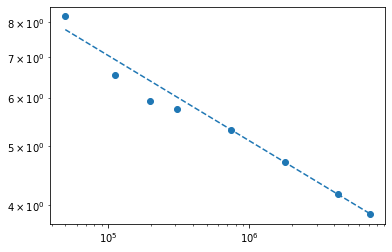


===============RAW NUMBERS===============

Parameters: [49856, 111648, 198016, 308960, 746944, 1776768, 4229344, 7099136]
Losses: [8.169562339782715, 6.550212860107422, 5.929893493652344, 5.758285999298096, 5.309444427490234, 4.712557315826416, 4.173392295837402, 3.8645176887512207]

===============SCALING LAW===============

Constant factor N_c: 1e+11, Exponent: 0.14


In [ ]:
try_scaling()

### softmax instead of sigmoid

In [ ]:
def forward(self, mod):       
    batch_size, seq_len, hidden_size = mod.shape

    # projections so each matrix has its own purpose
    q, f, k, v = self.projections(mod).chunk(4, dim = -1)

    # reshape for multihead formulation
    q = q.reshape(batch_size, seq_len, self.n_head, self.head_size)
    f = f.reshape(batch_size, seq_len, self.n_head, self.head_size)
    k = k.reshape(batch_size, seq_len, self.n_head, self.head_size)
    v = v.reshape(batch_size, seq_len, self.n_head, self.head_size)

    # dropout regularization (keys don't need dropout as they are always dotted with a dropped out vector)
    q = self.drop(q)
    f = self.drop(f)
    v = self.drop(v)

    # manual "matrix dot product" for speed (in einsum notation "bshe, bshe->bsh") with scaling
    focus_logits = (f * k).sum(dim = -1) / self.head_size**.5

    # apply dropout to logits so that all tokens will have a chance at getting focus
    focus_logits = self.drop(focus_logits)

    # manual softmax within cumulative sum
    focus_weights = F.elu(focus_logits) + 1
    focus_weights = focus_weights.unsqueeze(-1)

    # normalization term for softmax
    cumulative_weights = torch.cumsum(focus_weights, dim = 1)
    cumulative_weights = cumulative_weights - self._window_align(cumulative_weights)

    focused_k = self._w_focus(focus_weights, cumulative_weights, k)
    focused_v = self._w_focus(focus_weights, cumulative_weights, v)

    # querying by measuring dot product alignment (with scaling)
    alignment = F.softmax((q * focused_k).sum(dim = -1) / self.head_size**.5, dim = -1)
    attention = alignment.unsqueeze(-1) * focused_v

    # concat heads
    attention = attention.reshape(batch_size, seq_len, hidden_size)

    return attention

leap.MultiheadLeap.forward = forward

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,4.813200,4.304058


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,4.796100,4.241363
2000,4.065200,3.947401


<ipython-input-4-38cc3ad2ea7c>:13: RuntimeWarning: invalid value encountered in power
  return (n_c / n)**a


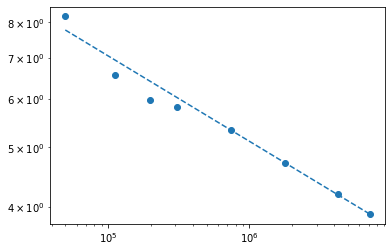


===============RAW NUMBERS===============

Parameters: [49856, 111648, 198016, 308960, 746944, 1776768, 4229344, 7099136]
Losses: [8.175233840942383, 6.552995681762695, 5.978828430175781, 5.809159278869629, 5.332766056060791, 4.707932472229004, 4.1932806968688965, 3.8900821208953857]

===============SCALING LAW===============

Constant factor N_c: 1e+11, Exponent: 0.139


In [ ]:
try_scaling()

# DIFFERENT IDEA

### Layernormed cumulative sum

In terms of making simplifications, why not just use a layer normed cumulative sum?

In [ ]:
def __init__(self, hidden_size, n_head, window_size, rescale = None, dropout = .1):
    super(MultiheadLeap, self).__init__()
    self.n_head = n_head
    self.hidden_size = hidden_size
    self.head_size = hidden_size // n_head
    self.window_size = window_size
    
    self.projections = nn.Linear(hidden_size, 2 * hidden_size, bias = False)

def forward(self, mod):       
    batch_size, seq_len, hidden_size = mod.shape

    # projections so each matrix has its own purpose
    q, v = self.projections(mod).chunk(2, dim = -1)
    
    cumsum = torch.cumsum(v, dim = 1)
    cumsum = cumsum - self._window_align(cumsum)
    cumsum = self._real_norm(cumsum)
    
    attention = q * cumsum # like mixer models/GLUs use a pointwise multiple
    return attention

leap.MultiheadLeap.__init__ = __init__
leap.MultiheadLeap.forward = forward

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,4.809200,4.327967


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,4.772000,4.232436
2000,4.086300,4.002289


<ipython-input-4-38cc3ad2ea7c>:13: RuntimeWarning: invalid value encountered in power
  return (n_c / n)**a


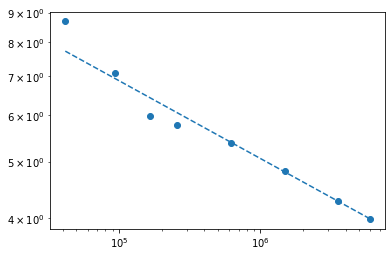


===============RAW NUMBERS===============

Parameters: [41664, 93216, 165248, 257760, 623040, 1481856, 3526880, 5919488]
Losses: [8.68909740447998, 7.094202041625977, 5.992490291595459, 5.789420127868652, 5.381399631500244, 4.826218605041504, 4.279183864593506, 3.9882235527038574]

===============SCALING LAW===============

Constant factor N_c: 2e+11, Exponent: 0.133


In [ ]:
try_scaling()

Not bad, the exponent is lower but that may be because less the test is smaller (less parameters)

### get rid of local linear attention

In [ ]:
def __init__(self, hidden_size, n_head, window_size, rescale = None, dropout = .1):
    super(MultiheadLeap, self).__init__()
    self.n_head = n_head
    self.hidden_size = hidden_size
    self.head_size = hidden_size // n_head
    self.window_size = window_size
    
    self.projections = nn.Linear(hidden_size, 2 * hidden_size, bias = False)

def forward(self, mod):       
    batch_size, seq_len, hidden_size = mod.shape

    # projections so each matrix has its own purpose
    q, v = self.projections(mod).chunk(2, dim = -1)
    
    cumsum = torch.cumsum(v, dim = 1)
#     cumsum = cumsum - self._window_align(cumsum)
    cumsum = self._real_norm(cumsum)
    
    attention = q * cumsum # like mixer models/GLUs use a pointwise multiple
    return attention

leap.MultiheadLeap.__init__ = __init__
leap.MultiheadLeap.forward = forward

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,5.056400,4.707183


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,5.040700,4.663051
2000,4.547100,4.495012


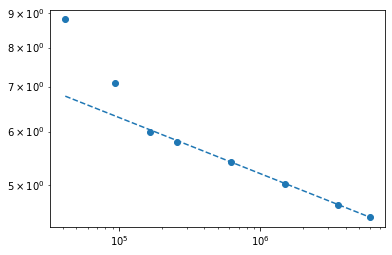


===============RAW NUMBERS===============

Parameters: [41664, 93216, 165248, 257760, 623040, 1481856, 3526880, 5919488]
Losses: [8.806496620178223, 7.094202041625977, 5.992490291595459, 5.789420127868652, 5.409177303314209, 5.017319202423096, 4.671738147735596, 4.483695030212402]

===============SCALING LAW===============

Constant factor N_c: 4e+14, Exponent: 0.0835


In [ ]:
try_scaling()

Seems like local linear attention is pretty useful, and stops saturation over long sequences. I'd like to make it "learned" somehow though...

### Learned cumulative sum - cumulative sum

This might work...?

In [ ]:
def __init__(self, hidden_size, n_head, window_size, rescale = None, dropout = .1):
    super(MultiheadLeap, self).__init__()
    self.n_head = n_head
    self.hidden_size = hidden_size
    self.head_size = hidden_size // n_head
    self.window_size = window_size
    
    self.projections = nn.Linear(hidden_size, 3 * hidden_size, bias = False)

def forward(self, mod):       
    batch_size, seq_len, hidden_size = mod.shape

    # projections so each matrix has its own purpose
    q, v, sub = self.projections(mod).chunk(3, dim = -1)
    
    learned_cumsum = torch.cumsum(v, dim = 1) - torch.cumsum(sub, dim = 1)
    learned_cumsum = self._real_norm(learned_cumsum)
    
    attention = q * learned_cumsum # like mixer models/GLUs use a pointwise multiple
    return attention

leap.MultiheadLeap.__init__ = __init__
leap.MultiheadLeap.forward = forward

Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,5.049400,4.689953


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,5.050300,4.664026
2000,4.542600,4.483044


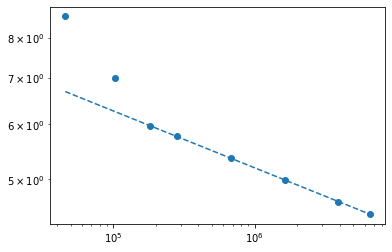


===============RAW NUMBERS===============

Parameters: [45760, 102432, 181632, 283360, 684992, 1629312, 3878112, 6509312]
Losses: [8.584019660949707, 6.9847187995910645, 5.961462497711182, 5.76399564743042, 5.355691432952881, 4.986752510070801, 4.635498046875, 4.456506252288818]

===============SCALING LAW===============

Constant factor N_c: 5e+14, Exponent: 0.0821


In [ ]:
try_scaling()

Unfortunely no dice... let's move on

### Use a GLU before cumsum

for a more non linear cumulative sum. Though from a different perspective at any index, the cumulative sum technically would equal a matrix of 'soft weights' multiplied by all the previous index vectors

In [ ]:
def __init__(self, hidden_size, n_head, window_size, rescale = None, dropout = .1):
    super(MultiheadLeap, self).__init__()
    self.n_head = n_head
    self.hidden_size = hidden_size
    self.head_size = hidden_size // n_head
    self.window_size = window_size
    
    self.projections = nn.Linear(hidden_size, 3 * hidden_size, bias = False)

def forward(self, mod):       
    batch_size, seq_len, hidden_size = mod.shape

    # projections so each matrix has its own purpose
    q, g, v = self.projections(mod).chunk(3, dim = -1)
    
    cumsum = torch.cumsum(F.gelu(g) * v, dim = 1)
    cumsum = cumsum - self._window_align(cumsum)
    cumsum = self._real_norm(cumsum)
    
    attention = q * cumsum # like mixer models/GLUs use a pointwise multiple
    return attention

leap.MultiheadLeap.__init__ = __init__
leap.MultiheadLeap.forward = forward

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,4.809900,4.295132


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,4.777300,4.203548
2000,4.044300,3.947665


<ipython-input-4-38cc3ad2ea7c>:13: RuntimeWarning: invalid value encountered in power
  return (n_c / n)**a


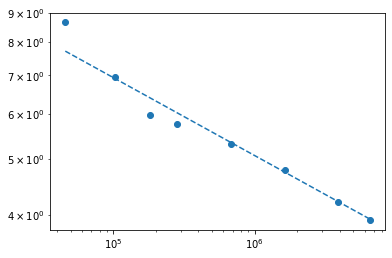


===============RAW NUMBERS===============

Parameters: [45760, 102432, 181632, 283360, 684992, 1629312, 3878112, 6509312]
Losses: [8.657310485839844, 6.963998317718506, 5.9705328941345215, 5.7668585777282715, 5.319812774658203, 4.792582988739014, 4.21990966796875, 3.9168989658355713]

===============SCALING LAW===============

Constant factor N_c: 2e+11, Exponent: 0.136


In [ ]:
try_scaling()

Apparently not bad

### Abalate q

In [ ]:
def __init__(self, hidden_size, n_head, window_size, rescale = None, dropout = .1):
    super(MultiheadLeap, self).__init__()
    self.n_head = n_head
    self.hidden_size = hidden_size
    self.head_size = hidden_size // n_head
    self.window_size = window_size
    
    self.projections = nn.Linear(hidden_size, 2 * hidden_size, bias = False)

def forward(self, mod):       
    batch_size, seq_len, hidden_size = mod.shape

    # projections so each matrix has its own purpose
    g, v = self.projections(mod).chunk(2, dim = -1)
    
    cumsum = torch.cumsum(F.gelu(g) * v, dim = 1)
    cumsum = cumsum - self._window_align(cumsum)
    cumsum = self._real_norm(cumsum)
    
    attention = cumsum # like mixer models/GLUs use a pointwise multiple
    return attention

leap.MultiheadLeap.__init__ = __init__
leap.MultiheadLeap.forward = forward

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8426, 'train_samples_per_second': 242.097, 'train_steps_per_second': 20.175, 'train_loss': 8.517623901367188, 'epoch': 1.0}
{'eval_loss': 8.146599769592285, 'eval_runtime': 0.163, 'eval_samples_per_second': 1300.297, 'eval_steps_per_second': 110.403, 'epoch': 1.0}
{'train_runtime': 1.3905, 'train_samples_per_second': 327.938, 'train_steps_per_second': 27.328, 'train_loss': 7.486122532894737, 'epoch': 1.0}
{'eval_loss': 6.888946533203125, 'eval_runtime': 0.1769, 'eval_samples_per_second': 1198.092, 'eval_steps_per_second': 101.725, 'epoch': 1.0}
{'train_runtime': 2.5079, 'train_samples_per_second': 321.781, 'train_steps_per_second': 27.114, 'train_loss': 6.614357892204733, 'epoch': 1.0}
{'eval_loss': 6.141276836395264, 'eval_runtime': 0.192, 'eval_samples_per_second': 1104.444, 'eval_steps_per_second': 93.774, 'epoch': 1.0}
{'train_runtime': 4.5702, 'train_samples_per_second': 275.483, 'train_steps_per_second': 22.975, 'train_loss': 6.3575055803571425, 'epoch': 1.0}


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 5.0995, 'learning_rate': 0.00023162004473494658, 'epoch': 0.7}
{'eval_loss': 4.479573726654053, 'eval_runtime': 0.5649, 'eval_samples_per_second': 375.274, 'eval_steps_per_second': 31.863, 'epoch': 0.7}
{'train_runtime': 161.2331, 'train_samples_per_second': 106.814, 'train_steps_per_second': 8.906, 'train_loss': 4.891569854821335, 'epoch': 1.0}
{'eval_loss': 4.416727542877197, 'eval_runtime': 0.5739, 'eval_samples_per_second': 369.374, 'eval_steps_per_second': 31.362, 'epoch': 1.0}


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 5.0881, 'learning_rate': 0.0006779441992943254, 'epoch': 0.42}
{'eval_loss': 4.388339996337891, 'eval_runtime': 0.7455, 'eval_samples_per_second': 284.369, 'eval_steps_per_second': 24.145, 'epoch': 0.42}
{'loss': 4.1946, 'learning_rate': 7.679451351994065e-05, 'epoch': 0.83}
{'eval_loss': 4.088709831237793, 'eval_runtime': 0.7543, 'eval_samples_per_second': 281.073, 'eval_steps_per_second': 23.865, 'epoch': 0.83}
{'train_runtime': 357.8075, 'train_samples_per_second': 80.781, 'train_steps_per_second': 6.733, 'train_loss': 4.544246054428056, 'epoch': 1.0}
{'eval_loss': 4.072990417480469, 'eval_runtime': 0.7481, 'eval_samples_per_second': 283.39, 'eval_steps_per_second': 24.061, 'epoch': 1.0}


<ipython-input-9-38cc3ad2ea7c>:13: RuntimeWarning: invalid value encountered in power
  return (n_c / n)**a


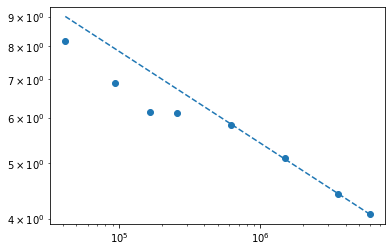


===============RAW NUMBERS===============

Parameters: [41664, 93216, 165248, 257760, 623040, 1481856, 3526880, 5919488]
Losses: [8.146599769592285, 6.888946533203125, 6.141276836395264, 6.110502243041992, 5.834442615509033, 5.098821640014648, 4.416727542877197, 4.072990417480469]

===============SCALING LAW===============

Constant factor N_c: 4e+10, Exponent: 0.16


In [ ]:
try_scaling()

not sure what happened with the logging, though I prefer the new format.  In terms of the number, that is an interestingly high exponent, but the loss is quite a bit worse. Let's see if an attention projection is better

### Attention projection

In [ ]:
def __init__(self, hidden_size, n_head, window_size, rescale = None, dropout = .1):
    super(MultiheadLeap, self).__init__()
    self.n_head = n_head
    self.hidden_size = hidden_size
    self.head_size = hidden_size // n_head
    self.window_size = window_size
    
    self.projections = nn.Linear(hidden_size, 2 * hidden_size, bias = False)
    self.attn_proj = nn.Linear(hidden_size, hidden_size)

def forward(self, mod):       
    batch_size, seq_len, hidden_size = mod.shape

    # projections so each matrix has its own purpose
    g, v = self.projections(mod).chunk(2, dim = -1)
    
    cumsum = torch.cumsum(F.gelu(g) * v, dim = 1)
    cumsum = cumsum - self._window_align(cumsum)
    cumsum = self._real_norm(cumsum)
    
    attention = self.attn_proj(cumsum)
    return attention

leap.MultiheadLeap.__init__ = __init__
leap.MultiheadLeap.forward = forward

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.685, 'train_samples_per_second': 327.005, 'train_steps_per_second': 27.737, 'train_loss': 8.410215678967928, 'epoch': 1.0}
{'eval_loss': 8.055327415466309, 'eval_runtime': 0.172, 'eval_samples_per_second': 1232.258, 'eval_steps_per_second': 104.626, 'epoch': 1.0}
{'train_runtime': 1.5552, 'train_samples_per_second': 322.154, 'train_steps_per_second': 27.007, 'train_loss': 7.3940480550130205, 'epoch': 1.0}
{'eval_loss': 6.753050804138184, 'eval_runtime': 0.1922, 'eval_samples_per_second': 1103.13, 'eval_steps_per_second': 93.662, 'epoch': 1.0}
{'train_runtime': 2.8982, 'train_samples_per_second': 306.398, 'train_steps_per_second': 25.533, 'train_loss': 6.570470449086782, 'epoch': 1.0}
{'eval_loss': 6.1319050788879395, 'eval_runtime': 0.1967, 'eval_samples_per_second': 1077.527, 'eval_steps_per_second': 91.488, 'epoch': 1.0}
{'train_runtime': 5.2265, 'train_samples_per_second': 264.993, 'train_steps_per_second': 22.194, 'train_loss': 6.352816877693965, 'epoch': 1.0}
{

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 5.2062, 'learning_rate': 0.00032669587727758196, 'epoch': 0.63}
{'eval_loss': 4.5690741539001465, 'eval_runtime': 0.6029, 'eval_samples_per_second': 351.641, 'eval_steps_per_second': 29.856, 'epoch': 0.63}
{'train_runtime': 197.9747, 'train_samples_per_second': 95.689, 'train_steps_per_second': 7.976, 'train_loss': 4.936178641050507, 'epoch': 1.0}
{'eval_loss': 4.455167293548584, 'eval_runtime': 0.6014, 'eval_samples_per_second': 352.493, 'eval_steps_per_second': 29.929, 'epoch': 1.0}


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 5.1812, 'learning_rate': 0.0007363688769950874, 'epoch': 0.38}
{'eval_loss': 4.491476058959961, 'eval_runtime': 0.7856, 'eval_samples_per_second': 269.868, 'eval_steps_per_second': 22.913, 'epoch': 0.38}
{'loss': 4.2607, 'learning_rate': 0.00015708098299419777, 'epoch': 0.75}
{'eval_loss': 4.118880748748779, 'eval_runtime': 0.7901, 'eval_samples_per_second': 268.322, 'eval_steps_per_second': 22.782, 'epoch': 0.75}
{'train_runtime': 426.9286, 'train_samples_per_second': 74.476, 'train_steps_per_second': 6.207, 'train_loss': 4.562934293926887, 'epoch': 1.0}
{'eval_loss': 4.070765495300293, 'eval_runtime': 0.7926, 'eval_samples_per_second': 267.47, 'eval_steps_per_second': 22.71, 'epoch': 1.0}


<ipython-input-9-38cc3ad2ea7c>:13: RuntimeWarning: invalid value encountered in power
  return (n_c / n)**a


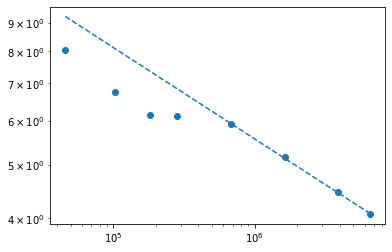


===============RAW NUMBERS===============

Parameters: [45824, 102528, 181760, 283520, 685344, 1630080, 3879680, 6511616]
Losses: [8.055327415466309, 6.753050804138184, 6.1319050788879395, 6.109683513641357, 5.908313751220703, 5.151345729827881, 4.455167293548584, 4.070765495300293]

===============SCALING LAW===============

Constant factor N_c: 3e+10, Exponent: 0.165


In [ ]:
try_scaling()

Weird that the exponent is better yet the loss is overall worse, maybe reintroducing the element-wise product will make it better with the same scaling but better loss (compare it to just having no attention projection though)

### attention proj and element wise product

In [ ]:
def __init__(self, hidden_size, n_head, window_size, rescale = None, dropout = .1):
    super(MultiheadLeap, self).__init__()
    self.n_head = n_head
    self.hidden_size = hidden_size
    self.head_size = hidden_size // n_head
    self.window_size = window_size
    
    self.projections = nn.Linear(hidden_size, 3 * hidden_size, bias = False)
    self.attn_proj = nn.Linear(hidden_size, hidden_size, bias = False)

def forward(self, mod):       
    batch_size, seq_len, hidden_size = mod.shape

    # projections so each matrix has its own purpose
    q, g, v = self.projections(mod).chunk(3, dim = -1)
    
    cumsum = torch.cumsum(F.gelu(g) * v, dim = 1)
    cumsum = cumsum - self._window_align(cumsum)
    cumsum = self._real_norm(cumsum)
    
    attention = q * self.attn_proj(cumsum)
    return attention

leap.MultiheadLeap.__init__ = __init__
leap.MultiheadLeap.forward = forward

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,4.787700,4.255251


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,4.756000,4.187829
2000,4.020700,3.912009


<ipython-input-4-38cc3ad2ea7c>:13: RuntimeWarning: invalid value encountered in power
  return (n_c / n)**a


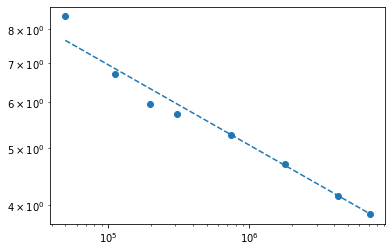


===============RAW NUMBERS===============

Parameters: [49856, 111648, 198016, 308960, 746944, 1776768, 4229344, 7099136]
Losses: [8.414606094360352, 6.708832263946533, 5.950713634490967, 5.72891902923584, 5.264035701751709, 4.7008233070373535, 4.151804447174072, 3.860186815261841]

===============SCALING LAW===============

Constant factor N_c: 1e+11, Exponent: 0.138


In [ ]:
try_scaling()

The exponent isn't better and nor is the loss compared to the best LEAP so far despite having the same number of params, maybe we'll come back to this idea

### Double the size of attention cumulative sum

In [ ]:
def __init__(self, hidden_size, n_head, window_size, rescale = None, dropout = .1):
    super(MultiheadLeap, self).__init__()
    self.n_head = n_head
    self.hidden_size = hidden_size
    self.head_size = hidden_size // n_head
    self.window_size = window_size
    
    self.Wq = nn.Linear(hidden_size, hidden_size, bias = False)
    self.up_proj = nn.Linear(hidden_size, hidden_size * 2, bias = False)
    self.down_proj = nn.Linear(2 * hidden_size, hidden_size, bias = False)

def forward(self, mod):       
    batch_size, seq_len, hidden_size = mod.shape

    # projections so each matrix has its own purpose
    q = self.Wq(mod)
    v = self.up_proj(mod)
    
    cumsum = torch.cumsum(v, dim = 1)
    cumsum = cumsum - self._window_align(cumsum)
    cumsum = self._real_norm(cumsum)
    
    attention = q * self.down_proj(cumsum)
    return attention

leap.MultiheadLeap.__init__ = __init__
leap.MultiheadLeap.forward = forward

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,4.821900,4.311574


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,4.809200,4.260767
2000,4.099400,3.990613
3000,3.938200,3.911628


<ipython-input-4-38cc3ad2ea7c>:13: RuntimeWarning: invalid value encountered in power
  return (n_c / n)**a


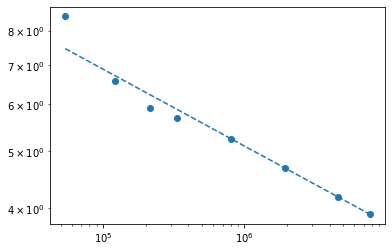


===============RAW NUMBERS===============

Parameters: [53952, 120864, 214400, 334560, 808896, 1924224, 4580576, 7688960]
Losses: [8.462088584899902, 6.585857391357422, 5.918907165527344, 5.688601493835449, 5.241556644439697, 4.683432579040527, 4.1756463050842285, 3.9111452102661133]

===============SCALING LAW===============

Constant factor N_c: 3e+11, Exponent: 0.13


In [ ]:
try_scaling()

### sigmoid activation on top of cumulative sum

In [ ]:
def __init__(self, hidden_size, n_head, window_size, rescale = None, dropout = .1):
    super(MultiheadLeap, self).__init__()
    self.n_head = n_head
    self.hidden_size = hidden_size
    self.head_size = hidden_size // n_head
    self.window_size = window_size
    
    self.projections = nn.Linear(hidden_size, 3 * hidden_size, bias = False)
    self.attn_proj = nn.Linear(hidden_size, hidden_size, bias = False)

def forward(self, mod):       
    batch_size, seq_len, hidden_size = mod.shape

    # projections so each matrix has its own purpose
    q, g, v = self.projections(mod).chunk(3, dim = -1)
    
    cumsum = torch.cumsum(F.gelu(g) * v, dim = 1)
    cumsum = cumsum - self._window_align(cumsum)
    cumsum = self._real_norm(cumsum)
    cumsum = torch.sigmoid(cumsum)
    
    attention = q * self.attn_proj(cumsum)
    return attention

leap.MultiheadLeap.__init__ = __init__
leap.MultiheadLeap.forward = forward

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,4.830900,4.318503


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,4.818800,4.256059
2000,4.081400,3.959093


<ipython-input-4-38cc3ad2ea7c>:13: RuntimeWarning: invalid value encountered in power
  return (n_c / n)**a


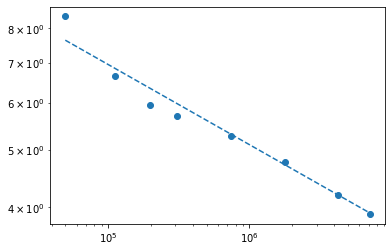


===============RAW NUMBERS===============

Parameters: [49856, 111648, 198016, 308960, 746944, 1776768, 4229344, 7099136]
Losses: [8.367063522338867, 6.647701263427734, 5.931532382965088, 5.702361583709717, 5.278954982757568, 4.766072750091553, 4.197415351867676, 3.898482322692871]

===============SCALING LAW===============

Constant factor N_c: 2e+11, Exponent: 0.135


In [ ]:
try_scaling()

### sigmoid activation after projection

like a sequence based GLU

In [ ]:
def __init__(self, hidden_size, n_head, window_size, rescale = None, dropout = .1):
    super(MultiheadLeap, self).__init__()
    self.n_head = n_head
    self.hidden_size = hidden_size
    self.head_size = hidden_size // n_head
    self.window_size = window_size
    
    self.projections = nn.Linear(hidden_size, 3 * hidden_size, bias = False)
    self.attn_proj = nn.Linear(hidden_size, hidden_size, bias = False)

def forward(self, mod):       
    batch_size, seq_len, hidden_size = mod.shape

    # projections so each matrix has its own purpose
    q, g, v = self.projections(mod).chunk(3, dim = -1)
    
    cumsum = torch.cumsum(F.gelu(g) * v, dim = 1)
    cumsum = cumsum - self._window_align(cumsum)
    cumsum = self._real_norm(cumsum)
    
    attention = q * torch.sigmoid(self.attn_proj(cumsum))
    return attention

leap.MultiheadLeap.__init__ = __init__
leap.MultiheadLeap.forward = forward

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,4.789500,4.265661


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,4.768900,4.194993
2000,4.017700,3.903637


<ipython-input-4-38cc3ad2ea7c>:13: RuntimeWarning: invalid value encountered in power
  return (n_c / n)**a


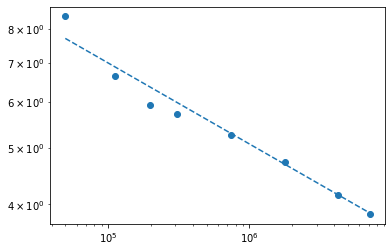


===============RAW NUMBERS===============

Parameters: [49856, 111648, 198016, 308960, 746944, 1776768, 4229344, 7099136]
Losses: [8.396749496459961, 6.6366705894470215, 5.915839195251465, 5.7113776206970215, 5.262801647186279, 4.730276584625244, 4.152303695678711, 3.847663164138794]

===============SCALING LAW===============

Constant factor N_c: 1e+11, Exponent: 0.139


In [ ]:
try_scaling()

### no attention projection

In [ ]:
def __init__(self, hidden_size, n_head, window_size, rescale = None, dropout = .1):
    super(MultiheadLeap, self).__init__()
    self.n_head = n_head
    self.hidden_size = hidden_size
    self.head_size = hidden_size // n_head
    self.window_size = window_size
    
    self.projections = nn.Linear(hidden_size, 3 * hidden_size, bias = False)

def forward(self, mod):       
    batch_size, seq_len, hidden_size = mod.shape

    # projections so each matrix has its own purpose
    q, g, v = self.projections(mod).chunk(3, dim = -1)
    
    cumsum = torch.cumsum(F.gelu(g) * v, dim = 1)
    cumsum = cumsum - self._window_align(cumsum)
    cumsum = self._real_norm(cumsum)
    
    attention = q * torch.sigmoid(cumsum)
    return attention

leap.MultiheadLeap.__init__ = __init__
leap.MultiheadLeap.forward = forward

Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,4.833700,4.326301


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,4.809500,4.240437
2000,4.069700,3.964447


<ipython-input-4-38cc3ad2ea7c>:13: RuntimeWarning: invalid value encountered in power
  return (n_c / n)**a


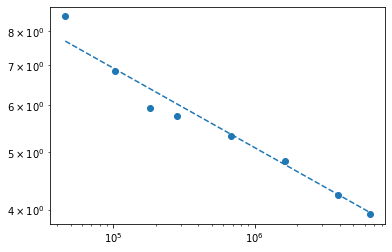


===============RAW NUMBERS===============

Parameters: [45760, 102432, 181632, 283360, 684992, 1629312, 3878112, 6509312]
Losses: [8.468684196472168, 6.863128185272217, 5.944465637207031, 5.756608963012695, 5.3193230628967285, 4.830646514892578, 4.241663932800293, 3.9308791160583496]

===============SCALING LAW===============

Constant factor N_c: 2e+11, Exponent: 0.134


In [ ]:
try_scaling()

just use an attention proj

### no GLU

In [ ]:
def __init__(self, hidden_size, n_head, window_size, rescale = None, dropout = .1):
    super(MultiheadLeap, self).__init__()
    self.n_head = n_head
    self.hidden_size = hidden_size
    self.head_size = hidden_size // n_head
    self.window_size = window_size
    
    self.projections = nn.Linear(hidden_size, 2 * hidden_size, bias = False)
    self.attn_proj = nn.Linear(hidden_size, hidden_size, bias = False)

def forward(self, mod):       
    batch_size, seq_len, hidden_size = mod.shape

    # projections so each matrix has its own purpose
    q, v = self.projections(mod).chunk(2, dim = -1)
    
    cumsum = torch.cumsum(v, dim = 1)
    cumsum = cumsum - self._window_align(cumsum)
    cumsum = self._real_norm(cumsum)
    
    attention = q * torch.sigmoid(self.attn_proj(cumsum))
    return attention

leap.MultiheadLeap.__init__ = __init__
leap.MultiheadLeap.forward = forward

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,4.829500,4.334913


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,4.811700,4.263203
2000,4.096700,3.992053


<ipython-input-4-38cc3ad2ea7c>:13: RuntimeWarning: invalid value encountered in power
  return (n_c / n)**a


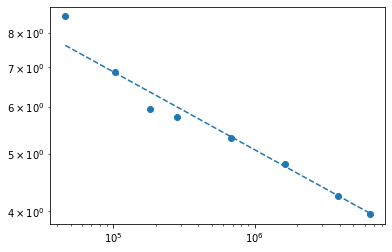


===============RAW NUMBERS===============

Parameters: [45760, 102432, 181632, 283360, 684992, 1629312, 3878112, 6509312]
Losses: [8.51335620880127, 6.854279041290283, 5.943164348602295, 5.75765323638916, 5.319281578063965, 4.802949905395508, 4.252818584442139, 3.95947265625]

===============SCALING LAW===============

Constant factor N_c: 2e+11, Exponent: 0.131


In [ ]:
try_scaling()

### sigmoid instead of gelu for GLU

In [ ]:
def __init__(self, hidden_size, n_head, window_size, rescale = None, dropout = .1):
    super(MultiheadLeap, self).__init__()
    self.n_head = n_head
    self.hidden_size = hidden_size
    self.head_size = hidden_size // n_head
    self.window_size = window_size
    
    self.projections = nn.Linear(hidden_size, 3 * hidden_size, bias = False)
    self.attn_proj = nn.Linear(hidden_size, hidden_size, bias = False)

def forward(self, mod):       
    batch_size, seq_len, hidden_size = mod.shape

    # projections so each matrix has its own purpose
    q, g, v = self.projections(mod).chunk(3, dim = -1)
    
    cumsum = torch.cumsum(torch.sigmoid(g) * v, dim = 1)
    cumsum = cumsum - self._window_align(cumsum)
    cumsum = self._real_norm(cumsum)
    
    attention = q * torch.sigmoid(self.attn_proj(cumsum))
    return attention

leap.MultiheadLeap.__init__ = __init__
leap.MultiheadLeap.forward = forward

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,4.800900,4.281248


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,4.787000,4.217910
2000,4.045100,3.929569


<ipython-input-4-38cc3ad2ea7c>:13: RuntimeWarning: invalid value encountered in power
  return (n_c / n)**a


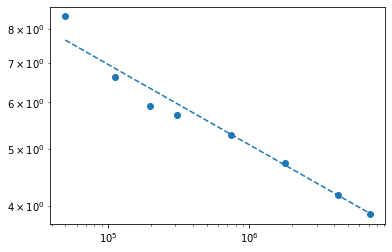


===============RAW NUMBERS===============

Parameters: [49856, 111648, 198016, 308960, 746944, 1776768, 4229344, 7099136]
Losses: [8.397673606872559, 6.632051467895508, 5.916284084320068, 5.712539196014404, 5.270501136779785, 4.729846954345703, 4.1696038246154785, 3.873706102371216]

===============SCALING LAW===============

Constant factor N_c: 1e+11, Exponent: 0.137


In [ ]:
try_scaling()

### elu + 1 instead of gelu for GLU

In [ ]:
def __init__(self, hidden_size, n_head, window_size, rescale = None, dropout = .1):
    super(MultiheadLeap, self).__init__()
    self.n_head = n_head
    self.hidden_size = hidden_size
    self.head_size = hidden_size // n_head
    self.window_size = window_size
    
    self.projections = nn.Linear(hidden_size, 3 * hidden_size, bias = False)
    self.attn_proj = nn.Linear(hidden_size, hidden_size, bias = False)

def forward(self, mod):       
    batch_size, seq_len, hidden_size = mod.shape

    # projections so each matrix has its own purpose
    q, g, v = self.projections(mod).chunk(3, dim = -1)
    
    g = F.elu(g) + 1
    
    cumsum = torch.cumsum(g * v, dim = 1)
    cumsum = cumsum - self._window_align(cumsum)
    cumsum = self._real_norm(cumsum)
    
    attention = q * torch.sigmoid(self.attn_proj(cumsum))
    return attention

leap.MultiheadLeap.__init__ = __init__
leap.MultiheadLeap.forward = forward

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,4.797200,4.274523


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,4.781000,4.207776
2000,4.035800,3.919958


<ipython-input-4-38cc3ad2ea7c>:13: RuntimeWarning: invalid value encountered in power
  return (n_c / n)**a


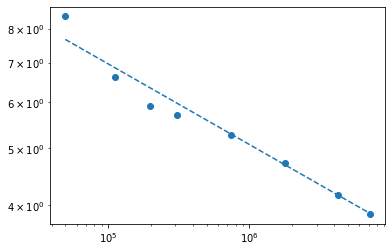


===============RAW NUMBERS===============

Parameters: [49856, 111648, 198016, 308960, 746944, 1776768, 4229344, 7099136]
Losses: [8.397407531738281, 6.6327643394470215, 5.9161272048950195, 5.7120842933654785, 5.268448829650879, 4.728302955627441, 4.162338733673096, 3.8643085956573486]

===============SCALING LAW===============

Constant factor N_c: 1e+11, Exponent: 0.138


In [ ]:
try_scaling()

### relu instead for GLU

In [ ]:
def __init__(self, hidden_size, n_head, window_size, rescale = None, dropout = .1):
    super(MultiheadLeap, self).__init__()
    self.n_head = n_head
    self.hidden_size = hidden_size
    self.head_size = hidden_size // n_head
    self.window_size = window_size
    
    self.projections = nn.Linear(hidden_size, 3 * hidden_size, bias = False)
    self.attn_proj = nn.Linear(hidden_size, hidden_size, bias = False)

def forward(self, mod):       
    batch_size, seq_len, hidden_size = mod.shape

    # projections so each matrix has its own purpose
    q, g, v = self.projections(mod).chunk(3, dim = -1)
    
    cumsum = torch.cumsum(F.relu(g) * v, dim = 1)
    cumsum = cumsum - self._window_align(cumsum)
    cumsum = self._real_norm(cumsum)
    
    attention = q * torch.sigmoid(self.attn_proj(cumsum))
    return attention

leap.MultiheadLeap.__init__ = __init__
leap.MultiheadLeap.forward = forward

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,4.793000,4.269006


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,4.773100,4.200158
2000,4.023900,3.908880


<ipython-input-4-38cc3ad2ea7c>:13: RuntimeWarning: invalid value encountered in power
  return (n_c / n)**a


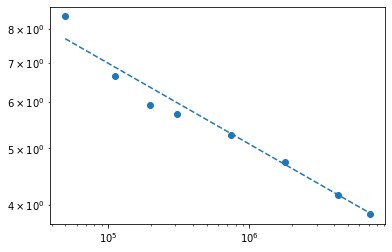


===============RAW NUMBERS===============

Parameters: [49856, 111648, 198016, 308960, 746944, 1776768, 4229344, 7099136]
Losses: [8.397584915161133, 6.635664463043213, 5.9159159660339355, 5.711607933044434, 5.264652252197266, 4.730910778045654, 4.156645774841309, 3.8526124954223633]

===============SCALING LAW===============

Constant factor N_c: 1e+11, Exponent: 0.138


In [ ]:
try_scaling()

### bilinear instead for GLU

In [ ]:
def __init__(self, hidden_size, n_head, window_size, rescale = None, dropout = .1):
    super(MultiheadLeap, self).__init__()
    self.n_head = n_head
    self.hidden_size = hidden_size
    self.head_size = hidden_size // n_head
    self.window_size = window_size
    
    self.projections = nn.Linear(hidden_size, 3 * hidden_size, bias = False)
    self.attn_proj = nn.Linear(hidden_size, hidden_size, bias = False)

def forward(self, mod):       
    batch_size, seq_len, hidden_size = mod.shape

    # projections so each matrix has its own purpose
    q, g, v = self.projections(mod).chunk(3, dim = -1)
    
    cumsum = torch.cumsum(g * v, dim = 1)
    cumsum = cumsum - self._window_align(cumsum)
    cumsum = self._real_norm(cumsum)
    
    attention = q * torch.sigmoid(self.attn_proj(cumsum))
    return attention

leap.MultiheadLeap.__init__ = __init__
leap.MultiheadLeap.forward = forward

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,4.795400,4.274944


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,4.775700,4.207930
2000,4.030800,3.915533


<ipython-input-4-38cc3ad2ea7c>:13: RuntimeWarning: invalid value encountered in power
  return (n_c / n)**a


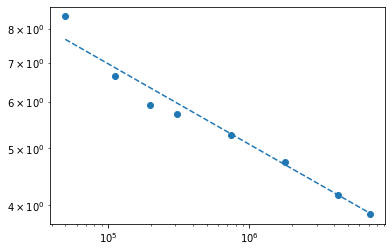


===============RAW NUMBERS===============

Parameters: [49856, 111648, 198016, 308960, 746944, 1776768, 4229344, 7099136]
Losses: [8.395841598510742, 6.638908386230469, 5.915149688720703, 5.710651874542236, 5.262763977050781, 4.7323527336120605, 4.159073352813721, 3.85872483253479]

===============SCALING LAW===============

Constant factor N_c: 1e+11, Exponent: 0.138


In [ ]:
try_scaling()

# Compare layernorm to manual normalizing to no normalizing

In [ ]:
def __init__(self, hidden_size, n_head, window_size, rescale = None, dropout = .1):
    super(MultiheadLeap, self).__init__()
    self.n_head = n_head
    self.hidden_size = hidden_size
    self.head_size = hidden_size // n_head
    self.window_size = window_size
    
    self.projections = nn.Linear(hidden_size, 3 * hidden_size, bias = False)
    self.attn_proj = nn.Linear(hidden_size, hidden_size, bias = False)

def forward(self, mod):       
    batch_size, seq_len, hidden_size = mod.shape

    # projections so each matrix has its own purpose
    q, g, v = self.projections(mod).chunk(3, dim = -1)
    
    cumsum = torch.cumsum(F.gelu(g) * v, dim = 1)
    cumsum = cumsum / (torch.arange(1, seq_len + 1).to(mod.device) ** .5).unsqueeze(-1)
    cumsum = cumsum - self._window_align(cumsum)
    
    attention = q * torch.sigmoid(self.attn_proj(cumsum))
    return attention

leap.MultiheadLeap.__init__ = __init__
leap.MultiheadLeap.forward = forward

Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,4.824100,4.318480


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,4.808200,4.254594
2000,4.082600,3.974733


<ipython-input-4-38cc3ad2ea7c>:13: RuntimeWarning: invalid value encountered in power
  return (n_c / n)**a


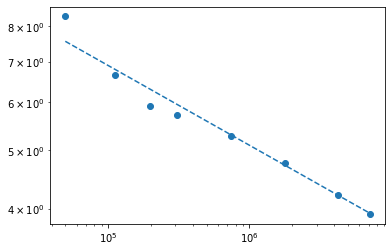


===============RAW NUMBERS===============

Parameters: [49856, 111648, 198016, 308960, 746944, 1776768, 4229344, 7099136]
Losses: [8.311040878295898, 6.653304100036621, 5.923936367034912, 5.7203288078308105, 5.275829792022705, 4.7592973709106445, 4.212874889373779, 3.9213664531707764]

===============SCALING LAW===============

Constant factor N_c: 2e+11, Exponent: 0.132


In [ ]:
try_scaling()

### no normalization/scaling

In [ ]:
def __init__(self, hidden_size, n_head, window_size, rescale = None, dropout = .1):
    super(MultiheadLeap, self).__init__()
    self.n_head = n_head
    self.hidden_size = hidden_size
    self.head_size = hidden_size // n_head
    self.window_size = window_size
    
    self.projections = nn.Linear(hidden_size, 3 * hidden_size, bias = False)
    self.attn_proj = nn.Linear(hidden_size, hidden_size, bias = False)

def forward(self, mod):       
    batch_size, seq_len, hidden_size = mod.shape

    # projections so each matrix has its own purpose
    q, g, v = self.projections(mod).chunk(3, dim = -1)
    
    cumsum = torch.cumsum(F.gelu(g) * v, dim = 1)
    cumsum = cumsum - self._window_align(cumsum)
    
    attention = q * torch.sigmoid(self.attn_proj(cumsum))
    return attention

leap.MultiheadLeap.__init__ = __init__
leap.MultiheadLeap.forward = forward

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,4.841700,4.349355


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,4.822000,4.281699
2000,4.117100,4.012824


<ipython-input-4-38cc3ad2ea7c>:13: RuntimeWarning: invalid value encountered in power
  return (n_c / n)**a


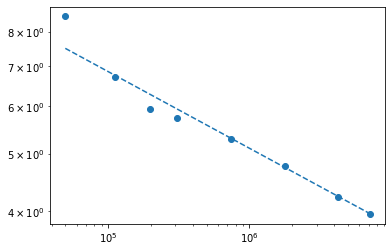


===============RAW NUMBERS===============

Parameters: [49856, 111648, 198016, 308960, 746944, 1776768, 4229344, 7099136]
Losses: [8.48288631439209, 6.707395076751709, 5.9454216957092285, 5.735185623168945, 5.282209396362305, 4.770532131195068, 4.234993934631348, 3.957691192626953]

===============SCALING LAW===============

Constant factor N_c: 3e+11, Exponent: 0.128


In [ ]:
try_scaling()

### residual connection with attn proj

In [ ]:
def __init__(self, hidden_size, n_head, window_size, rescale = None, dropout = .1):
    super(MultiheadLeap, self).__init__()
    self.n_head = n_head
    self.hidden_size = hidden_size
    self.head_size = hidden_size // n_head
    self.window_size = window_size
    
    self.projections = nn.Linear(hidden_size, 3 * hidden_size, bias = False)
    self.attn_proj = nn.Linear(hidden_size, hidden_size, bias = False)

def forward(self, mod):       
    batch_size, seq_len, hidden_size = mod.shape

    # projections so each matrix has its own purpose
    q, g, v = self.projections(mod).chunk(3, dim = -1)
    
    cumsum = torch.cumsum(F.gelu(g) * v, dim = 1)
    cumsum = cumsum - self._window_align(cumsum)
    cumsum = self._real_norm(cumsum)
    
    attention = q * torch.sigmoid(self.attn_proj(v + cumsum))
    return attention

leap.MultiheadLeap.__init__ = __init__
leap.MultiheadLeap.forward = forward

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,4.834600,4.322773


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,4.817600,4.254973
2000,4.075700,3.952981


<ipython-input-4-38cc3ad2ea7c>:13: RuntimeWarning: invalid value encountered in power
  return (n_c / n)**a


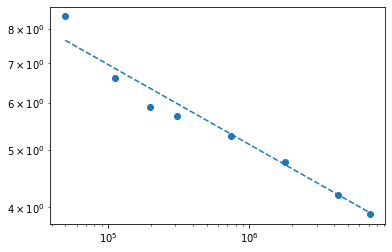


===============RAW NUMBERS===============

Parameters: [49856, 111648, 198016, 308960, 746944, 1776768, 4229344, 7099136]
Losses: [8.396687507629395, 6.622316837310791, 5.911603927612305, 5.709158420562744, 5.281710147857666, 4.773544788360596, 4.199790000915527, 3.8938586711883545]

===============SCALING LAW===============

Constant factor N_c: 2e+11, Exponent: 0.135


In [ ]:
try_scaling()

### sigmoid before projection

In [ ]:
def __init__(self, hidden_size, n_head, window_size, rescale = None, dropout = .1):
    super(MultiheadLeap, self).__init__()
    self.n_head = n_head
    self.hidden_size = hidden_size
    self.head_size = hidden_size // n_head
    self.window_size = window_size
    
    self.projections = nn.Linear(hidden_size, 3 * hidden_size, bias = False)
    self.attn_proj = nn.Linear(hidden_size, hidden_size, bias = False)

def forward(self, mod):       
    batch_size, seq_len, hidden_size = mod.shape

    # projections so each matrix has its own purpose
    q, g, v = self.projections(mod).chunk(3, dim = -1)
    
    cumsum = torch.cumsum(F.gelu(g) * v, dim = 1)
    cumsum = cumsum - self._window_align(cumsum)
    cumsum = self._real_norm(cumsum)
    cumsum = torch.sigmoid(cumsum)
    
    attention = q * self.attn_proj(cumsum)
    return attention

leap.MultiheadLeap.__init__ = __init__
leap.MultiheadLeap.forward = forward

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,4.830900,4.318503


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,4.818800,4.256059
2000,4.081400,3.959093


<ipython-input-4-38cc3ad2ea7c>:13: RuntimeWarning: invalid value encountered in power
  return (n_c / n)**a


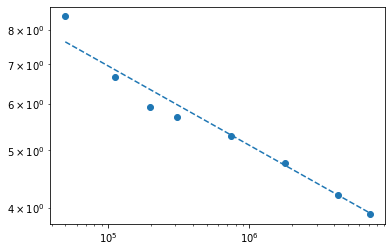


===============RAW NUMBERS===============

Parameters: [49856, 111648, 198016, 308960, 746944, 1776768, 4229344, 7099136]
Losses: [8.428759574890137, 6.647701263427734, 5.931532382965088, 5.702361583709717, 5.278954982757568, 4.766072750091553, 4.197415351867676, 3.898482322692871]

===============SCALING LAW===============

Constant factor N_c: 2e+11, Exponent: 0.135


In [ ]:
try_scaling()

### ablate q again

In [ ]:
def __init__(self, hidden_size, n_head, window_size, rescale = None, dropout = .1):
    super(MultiheadLeap, self).__init__()
    self.n_head = n_head
    self.hidden_size = hidden_size
    self.head_size = hidden_size // n_head
    self.window_size = window_size
    
    self.projections = nn.Linear(hidden_size, 2 * hidden_size, bias = False)
    self.attn_proj = nn.Linear(hidden_size, hidden_size, bias = False)

def forward(self, mod):       
    batch_size, seq_len, hidden_size = mod.shape

    # projections so each matrix has its own purpose
    g, v = self.projections(mod).chunk(2, dim = -1)
    
    cumsum = torch.cumsum(F.gelu(g) * v, dim = 1)
    cumsum = cumsum - self._window_align(cumsum)
    cumsum = self._real_norm(cumsum)
    cumsum = torch.sigmoid(cumsum)
    
    attention = self.attn_proj(cumsum)
    return attention

leap.MultiheadLeap.__init__ = __init__
leap.MultiheadLeap.forward = forward

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,5.072700,4.480018


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,5.093500,4.458890
2000,4.221400,4.080879


<ipython-input-4-38cc3ad2ea7c>:13: RuntimeWarning: invalid value encountered in power
  return (n_c / n)**a


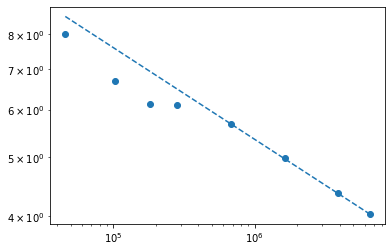


===============RAW NUMBERS===============

Parameters: [45760, 102432, 181632, 283360, 684992, 1629312, 3878112, 6509312]
Losses: [8.011161804199219, 6.685704708099365, 6.126079082489014, 6.108285427093506, 5.670403957366943, 4.983748435974121, 4.358693599700928, 4.028817653656006]

===============SCALING LAW===============

Constant factor N_c: 6e+10, Exponent: 0.152


In [ ]:
try_scaling()

While the scaling is solid, the loss really is quite high, though parameter matching should be used

In [ ]:
def __init__(self, hidden_size, n_head, window_size, rescale = None, dropout = .1):
    super(MultiheadLeap, self).__init__()
    self.n_head = n_head
    self.hidden_size = hidden_size
    self.head_size = hidden_size // n_head
    self.window_size = window_size
    
    self.projections = nn.Linear(hidden_size, 3 * hidden_size, bias = False)
    self.attn_proj = nn.Linear(int(1.5 * hidden_size), hidden_size, bias = False)

def forward(self, mod):       
    batch_size, seq_len, hidden_size = mod.shape

    # projections so each matrix has its own purpose
    g, v = self.projections(mod).chunk(2, dim = -1)
    
    cumsum = torch.cumsum(F.gelu(g) * v, dim = 1)
    cumsum = cumsum - self._window_align(cumsum)
    cumsum = self._real_norm(cumsum)
    cumsum = torch.sigmoid(cumsum)
    
    attention = self.attn_proj(cumsum)
    return attention

leap.MultiheadLeap.__init__ = __init__
leap.MultiheadLeap.forward = forward

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,5.215700,4.572790


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,5.273500,4.572092
2000,4.296900,4.118389
3000,4.033800,4.006075


<ipython-input-4-38cc3ad2ea7c>:13: RuntimeWarning: invalid value encountered in power
  return (n_c / n)**a


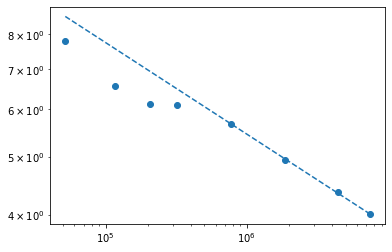


===============RAW NUMBERS===============

Parameters: [51904, 116256, 206208, 321760, 777920, 1850496, 4404960, 7394048]
Losses: [7.815647125244141, 6.549789905548096, 6.125542640686035, 6.105160713195801, 5.6711907386779785, 4.940231800079346, 4.360311985015869, 4.006074905395508]

===============SCALING LAW===============

Constant factor N_c: 6e+10, Exponent: 0.153


In [ ]:
try_scaling()

### use a gated q even more like a GLU

In [ ]:
def __init__(self, hidden_size, n_head, window_size, rescale = None, dropout = .1):
    super(MultiheadLeap, self).__init__()
    self.n_head = n_head
    self.hidden_size = hidden_size
    self.head_size = hidden_size // n_head
    self.window_size = window_size
    
    self.projections = nn.Linear(hidden_size, 3 * hidden_size, bias = False)
    self.attn_proj = nn.Linear(hidden_size, hidden_size, bias = False)

def forward(self, mod):       
    batch_size, seq_len, hidden_size = mod.shape

    # projections so each matrix has its own purpose
    q, g, v = self.projections(mod).chunk(3, dim = -1)
    
    cumsum = torch.cumsum(F.gelu(g) * v, dim = 1)
    cumsum = cumsum - self._window_align(cumsum)
    cumsum = self._real_norm(cumsum)
    cumsum = torch.sigmoid(cumsum)
    
    attention = torch.sigmoid(q) * self.attn_proj(cumsum)
    return attention

leap.MultiheadLeap.__init__ = __init__
leap.MultiheadLeap.forward = forward

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,4.868300,4.347616


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,4.859000,4.308300
2000,4.121600,3.997885


<ipython-input-4-38cc3ad2ea7c>:13: RuntimeWarning: invalid value encountered in power
  return (n_c / n)**a


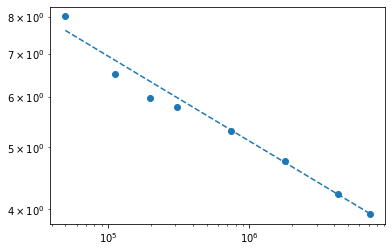


===============RAW NUMBERS===============

Parameters: [49856, 111648, 198016, 308960, 746944, 1776768, 4229344, 7099136]
Losses: [8.00336742401123, 6.511664390563965, 5.977105140686035, 5.778717041015625, 5.305574417114258, 4.756036281585693, 4.22504186630249, 3.9332385063171387]

===============SCALING LAW===============

Constant factor N_c: 2e+11, Exponent: 0.133


In [ ]:
try_scaling()

### use carefully selected biases (for final GLU)

In [ ]:
def __init__(self, hidden_size, n_head, window_size, rescale = None, dropout = .1):
    super(MultiheadLeap, self).__init__()
    self.n_head = n_head
    self.hidden_size = hidden_size
    self.head_size = hidden_size // n_head
    self.window_size = window_size
    
    # no biases on projections that are going to be cumsumed
    self.Wq = nn.Linear(hidden_size, hidden_size)
    self.projections = nn.Linear(hidden_size, 2 * hidden_size, bias = False)
    self.attn_proj = nn.Linear(hidden_size, hidden_size)

def forward(self, mod):       
    batch_size, seq_len, hidden_size = mod.shape

    # projections so each matrix has its own purpose
    g, v = self.projections(mod).chunk(2, dim = -1)
    
    cumsum = torch.cumsum(F.gelu(g) * v, dim = 1)
    cumsum = cumsum - self._window_align(cumsum)
    cumsum = self._real_norm(cumsum)
    cumsum = torch.sigmoid(cumsum)
    
    q = self.Wq(mod)
    attention = torch.sigmoid(q) * self.attn_proj(cumsum)
    return attention

leap.MultiheadLeap.__init__ = __init__
leap.MultiheadLeap.forward = forward

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,4.862600,4.363294


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,4.848200,4.316412
2000,4.118600,3.996225


<ipython-input-4-38cc3ad2ea7c>:13: RuntimeWarning: invalid value encountered in power
  return (n_c / n)**a


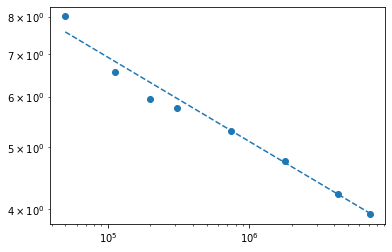


===============RAW NUMBERS===============

Parameters: [49984, 111840, 198272, 309280, 747648, 1778304, 4232480, 7103744]
Losses: [8.01374626159668, 6.561185836791992, 5.9494524002075195, 5.7699103355407715, 5.295731544494629, 4.7547807693481445, 4.230751037597656, 3.931230306625366]

===============SCALING LAW===============

Constant factor N_c: 2e+11, Exponent: 0.132


In [ ]:
try_scaling()

### gelu for final GLU

In [ ]:
def __init__(self, hidden_size, n_head, window_size, rescale = None, dropout = .1):
    super(MultiheadLeap, self).__init__()
    self.n_head = n_head
    self.hidden_size = hidden_size
    self.head_size = hidden_size // n_head
    self.window_size = window_size
    
    # no biases on projections that are going to be cumsumed
    self.Wq = nn.Linear(hidden_size, hidden_size)
    self.projections = nn.Linear(hidden_size, 2 * hidden_size, bias = False)
    self.attn_proj = nn.Linear(hidden_size, hidden_size)

def forward(self, mod):       
    batch_size, seq_len, hidden_size = mod.shape

    # projections so each matrix has its own purpose
    g, v = self.projections(mod).chunk(2, dim = -1)
    
    cumsum = torch.cumsum(F.gelu(g) * v, dim = 1)
    cumsum = cumsum - self._window_align(cumsum)
    cumsum = self._real_norm(cumsum)
    cumsum = torch.sigmoid(cumsum)
    
    q = self.Wq(mod)
    attention = F.gelu(q) * self.attn_proj(cumsum)
    return attention

leap.MultiheadLeap.__init__ = __init__
leap.MultiheadLeap.forward = forward

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,4.840000,4.333302


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,4.810800,4.266363
2000,4.086600,3.968687


<ipython-input-4-38cc3ad2ea7c>:13: RuntimeWarning: invalid value encountered in power
  return (n_c / n)**a


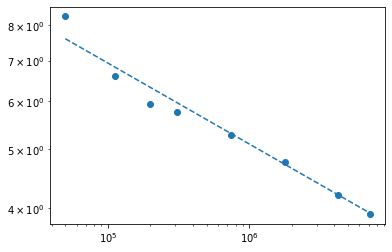


===============RAW NUMBERS===============

Parameters: [49984, 111840, 198272, 309280, 747648, 1778304, 4232480, 7103744]
Losses: [8.274867057800293, 6.607009410858154, 5.926080703735352, 5.7517828941345215, 5.2804179191589355, 4.760326862335205, 4.208000659942627, 3.907820224761963]

===============SCALING LAW===============

Constant factor N_c: 2e+11, Exponent: 0.133


In [ ]:
try_scaling()

# Idea: move the MLP layer into the cumsum attention

# Appendix

In [ ]:
raw_datasets = load_dataset("wikitext", "wikitext-103-v1")

# make a word level tokenizer
tokenizer = Tokenizer(WordLevel(unk_token="<unk>"))
tokenizer.pre_tokenizer = Whitespace()
tokenizer.enable_padding(pad_id = 0, pad_token = "<pad>")
# no post processing

# only use vocab size of 8192 for reasonable speed/memory
token_trainer = WordLevelTrainer(vocab_size = 8191, # -1 for pad token
                                 special_tokens = ["<unk>"])

def batch_iterator(batch_size=10000):
    text = raw_datasets["train"]['text']
    for i in range(0, len(text), batch_size):
        yield text[i : i + batch_size]

tokenizer.train_from_iterator(batch_iterator(),
                              trainer = token_trainer,
                              length = len(raw_datasets["train"]["text"]))
tokenizer = PreTrainedTokenizerFast(tokenizer_object = tokenizer, pad_token = "<pad>")

# tokenized the dataset
def tokenize_function(examples):
    output = tokenizer(examples["text"])
    return output

# tokenize dataset
tokenized_datasets = raw_datasets.map(
    tokenize_function,
    batched = True,
    remove_columns = "text",
    desc = f"tokenize dataset",
    load_from_cache_file = True
)

def group_texts(examples):
    # Concatenate all texts
    concatenated_examples = {k: list(chain(*examples[k])) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])

    # Split by chunks of max_len
    result = {
        k: [t[i : i + seq_len] for i in range(0, total_length, seq_len)]
        for k, t in concatenated_examples.items()
    }
    
    # for language modeling, inputs are labels (they will be shifted inside the model)
    result["labels"] = result["input_ids"].copy()
    
    # pad last block with 0
    last_ids = result["input_ids"][-1]
    diff = seq_len - len(last_ids)
    result["input_ids"][-1] = last_ids + [0 for _ in range(diff)]
    
    # set attention mask to mask out these tokens
    result["attention_mask"][-1] = result["attention_mask"][-1] + [0 for _ in range(diff)]
    
    # set pad labels to -100 so they will be ignored by CrossEntropyLoss
    result["labels"][-1] = result["labels"][-1] + [-100 for _ in range(diff)]
    return result

lm_dataset = tokenized_datasets.map(
    group_texts,
    batched = True,
    batch_size = 10000,
    desc = f"Grouping texts in chunks of {seq_len}",
    load_from_cache_file = True
)

lm_dataset = lm_dataset.remove_columns(["token_type_ids"])

Found cached dataset wikitext (C:/Users/micha/.cache/huggingface/datasets/wikitext/wikitext-103-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at C:/Users/micha/.cache/huggingface/datasets/wikitext/wikitext-103-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126\cache-a2031eb206d20f87.arrow
Loading cached processed dataset at C:/Users/micha/.cache/huggingface/datasets/wikitext/wikitext-103-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126\cache-8f3dd2e5d5819fe2.arrow
Loading cached processed dataset at C:/Users/micha/.cache/huggingface/datasets/wikitext/wikitext-103-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126\cache-f4668efef485cbea.arrow
Loading cached processed dataset at C:/Users/micha/.cache/huggingface/datasets/wikitext/wikitext-103-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126\cache-c465af52033c5930.arrow
Loading cached processed dataset at C:/Users/micha/.cache/huggingface/datasets/wikitext/wikitext-103-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126\cache-f4b

In [ ]:
len(tokenizer) + 1

8192